<a href="https://colab.research.google.com/github/gc2321/3546-Deep-Learning/blob/main/assign_2/assign_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying Flowers using Transfer Learning in Keras

Assignment 2 - Convolutional Neural Nets and Transfer Learning

By Gordon Chan (qq525548)


In [1]:
import os
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
random.seed(42)


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
data_dir = "/content/gdrive/MyDrive/3546/assign_2/flower_photos"

In [4]:
os.listdir(data_dir)

['tulips', 'roses', 'sunflowers', 'dandelion', 'daisy']

In [5]:
class_names = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

## Loading data

In [6]:
from sklearn.model_selection import train_test_split

# Get the list of classes (folders)
classes = ['tulips', 'roses', 'sunflowers', 'dandelion', 'daisy']

# Initialize the lists to store the images and labels
images = []
labels = []

# Desired dimensions
target_height = 224
target_width = 224

# Loop through each class folder
for class_ in classes:
    # Get the list of images in the current class folder
    image_paths = tf.io.gfile.glob(f'{data_dir}/{class_}/*.jpg')

    # Loop through each image
    for image_path in image_paths:
        # Read the image
        image = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image, channels=3)

        # Add the image and label to the lists
        images.append(image)
        labels.append(class_)

# Split the data into training and testing sets (80% for training and 20% for testing)
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)

# Print the shapes of the training and testing sets
print(f'Training images shape: {len(train_images)}')
print(f'Testing images shape: {len(test_images)}')

Training images shape: 2936
Testing images shape: 734


In [7]:
# split off 15% of training set as validation set
validation_images, remaining_images, validation_labels, remaining_labels = train_test_split(
    train_images, train_labels, test_size=0.85, random_state=42, stratify=train_labels
)

# Update the training data to be the remaining images and labels
train_images = remaining_images
train_labels = remaining_labels

In [8]:
print(f'Training images shape: {len(train_images)}')
print(f'Validation images shape: {len(validation_images)}')
print(f'Testing images shape: {len(test_images)}')

Training images shape: 2496
Validation images shape: 440
Testing images shape: 734


In [9]:
def show_images(images, num, labels):
    plt.figure(figsize=(10, 10))
    for i in range(num):
      plt.subplot(3, 3, i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(images[i], cmap=plt.cm.binary)
      plt.xlabel(labels[i])
    plt.show()

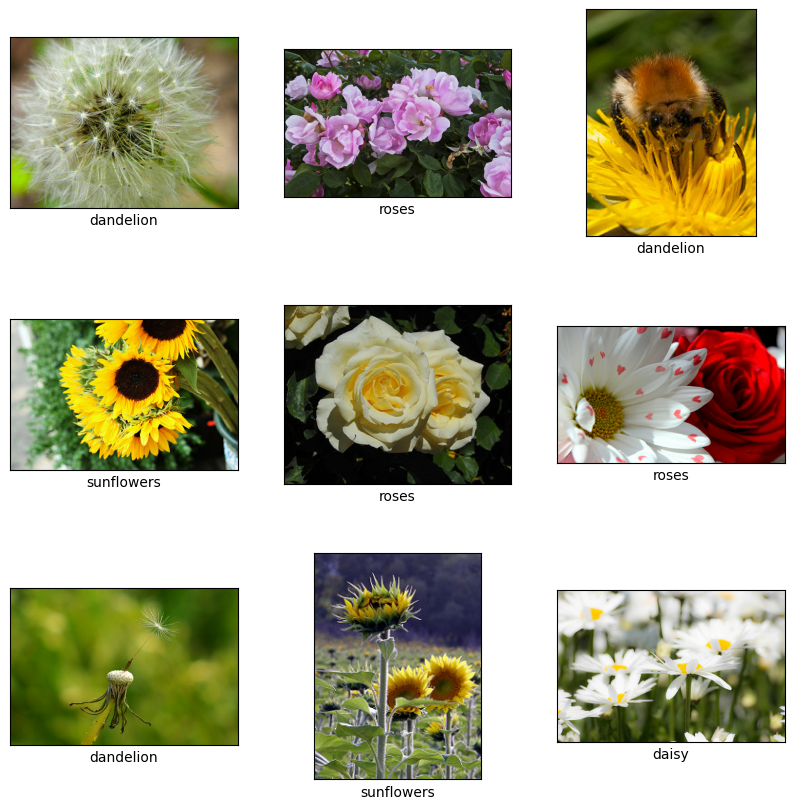

In [10]:
show_images(train_images, 9, train_labels)

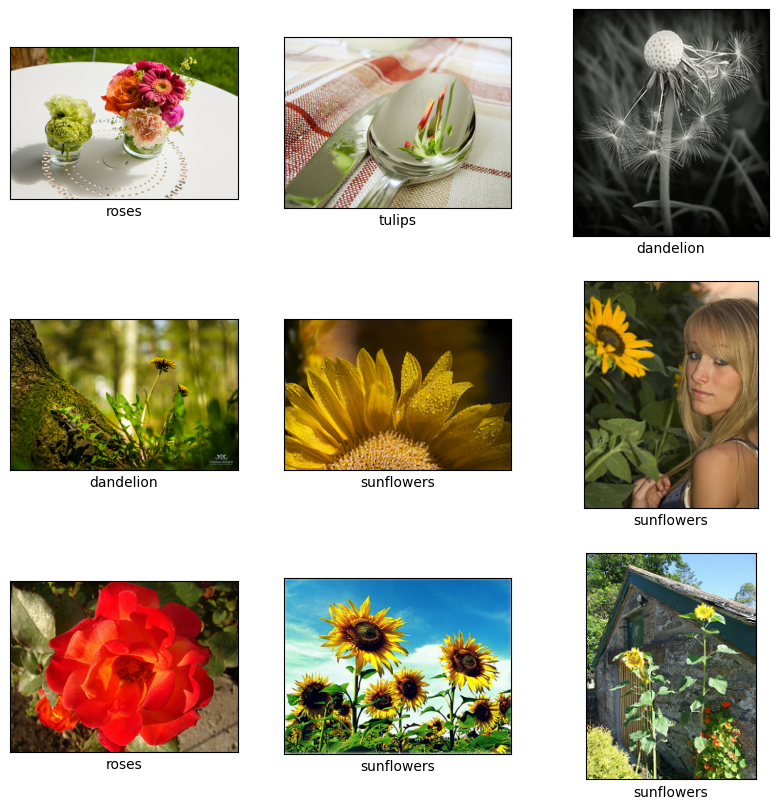

In [11]:
show_images(validation_images, 9, validation_labels)

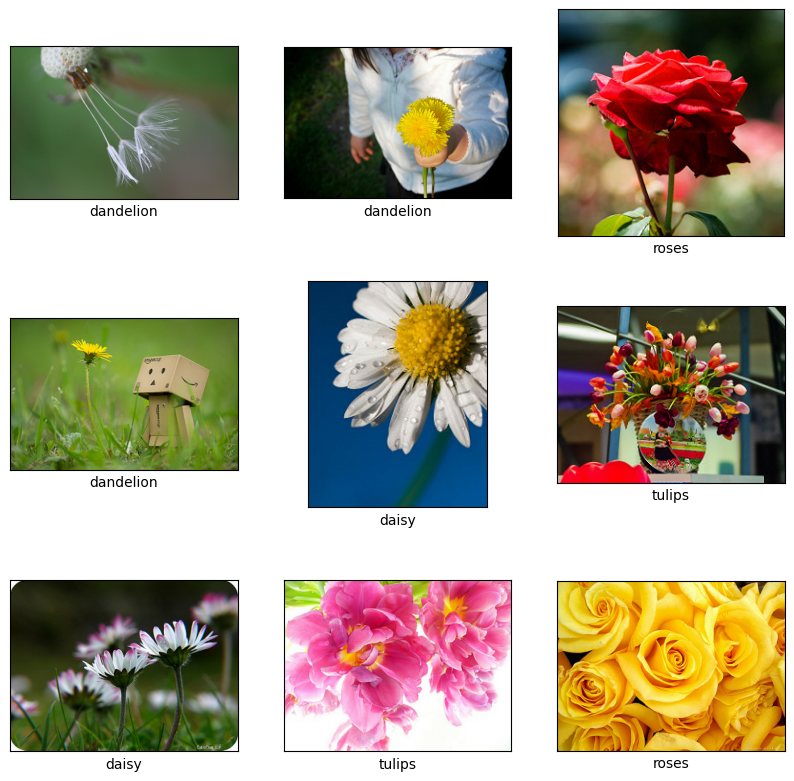

In [12]:
show_images(test_images, 9, test_labels)

### Preprocessing Images

In [13]:
def string_to_tensor(str):
   index = class_names.index(str)
   return tf.convert_to_tensor(index, dtype=tf.int64)

In [14]:
preprocess = tf.keras.Sequential([
    tf.keras.layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True),
    tf.keras.layers.Lambda(tf.keras.applications.xception.preprocess_input)
])

In [15]:
def transform_images(images, labels):
  labels = [string_to_tensor(s) for s in labels]
  image_set = [preprocess(x) for x in images]
  dataset = tf.data.Dataset.from_tensor_slices((image_set, labels))
  return dataset

In [16]:
def show_dataset_images(dataset):
  plt.figure(figsize=(12, 10))
  index = 0
  for image, label in dataset.take(9):
      index += 1
      plt.subplot(3, 3, index)
      image = np.clip(image, 0, 255)
      plt.imshow(image)
      plt.title(f"Label: {class_names[label]}")
      plt.axis("off")

  plt.show()

In [17]:
train_dataset = transform_images(train_images, train_labels)

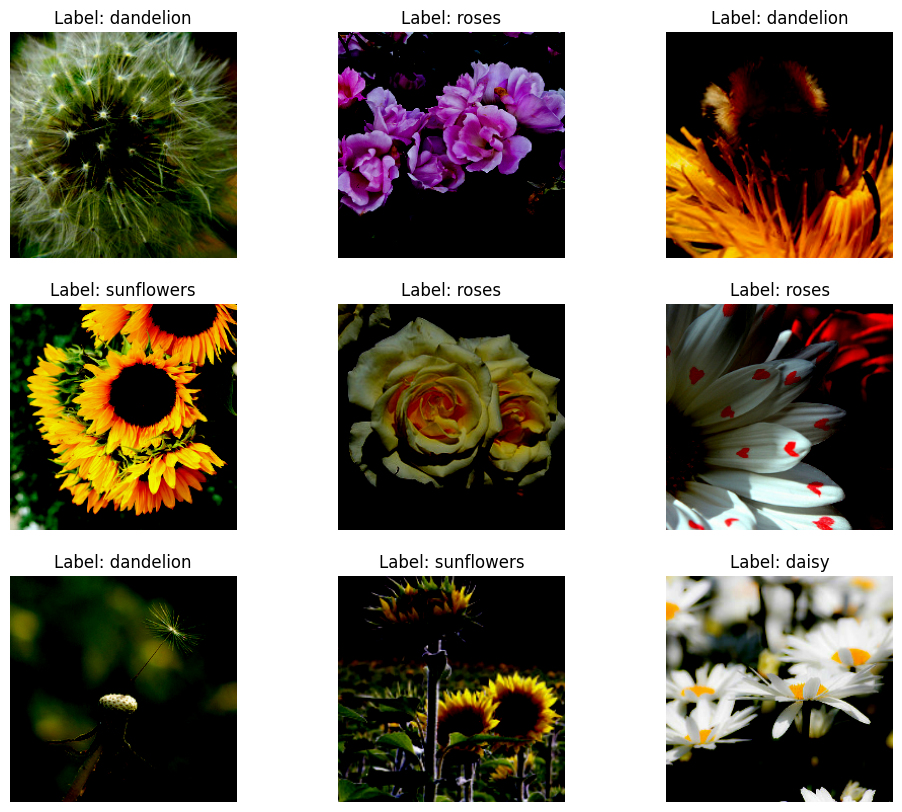

In [18]:
show_dataset_images(train_dataset)

In [19]:
validation_dataset = transform_images(validation_images, validation_labels)

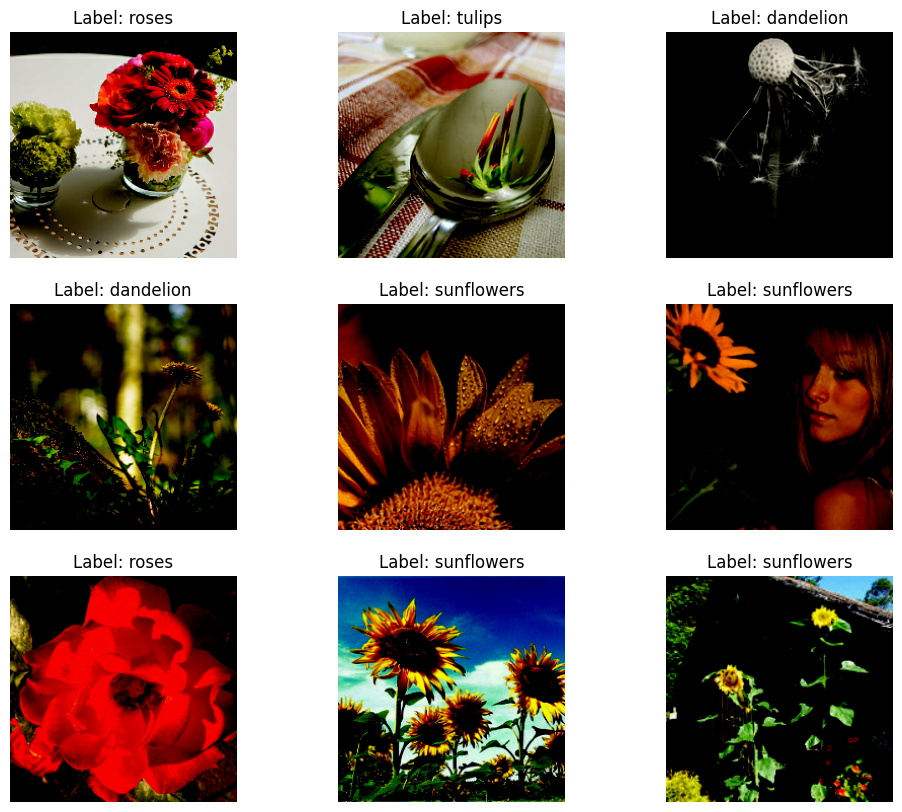

In [20]:
show_dataset_images(validation_dataset)

In [21]:
test_dataset = transform_images(test_images, test_labels)

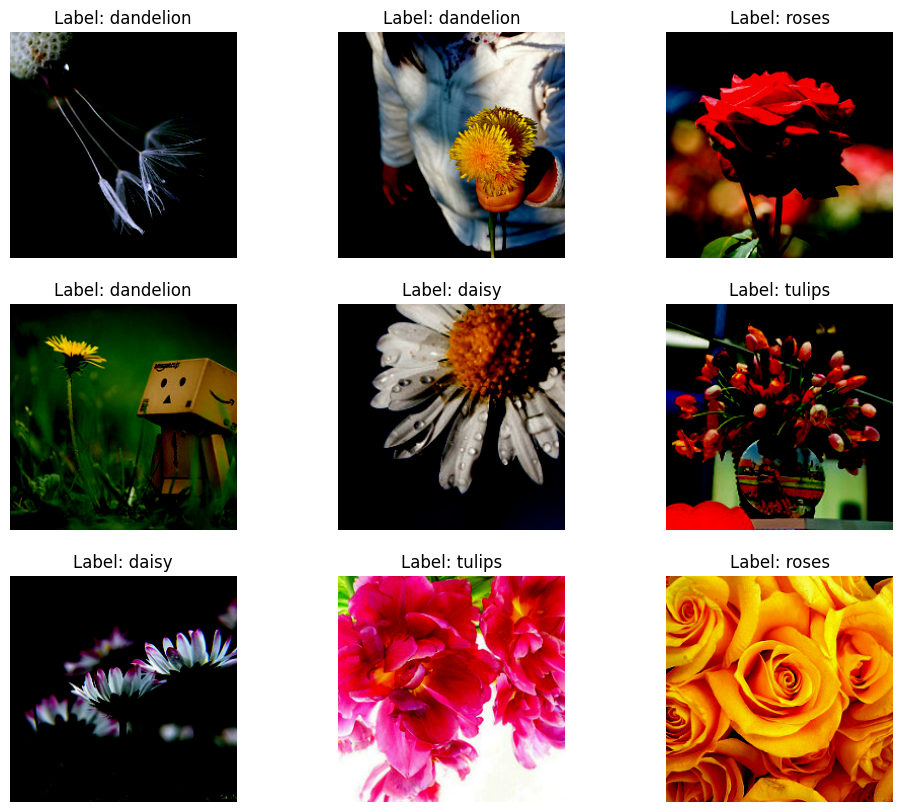

In [22]:
show_dataset_images(test_dataset)

### Batching

In [23]:
batch_size = 32

In [24]:
# shuffling the data set to ensure training model does not learn any unintended patterns due to the order of the data
# Prefetching improves the efficiency of data loading by overlapping the data preprocessing and model training.
train_set = train_dataset.shuffle(1000, seed=42).batch(batch_size).prefetch(1)

In [25]:
valid_set = validation_dataset.batch(batch_size)
test_set = test_dataset.batch(batch_size)

## Loading VGG16 Model

In [26]:
# Ensure reproducibility
tf.random.set_seed(42)

# Load the VGG16 model, excluding the top layers
base_model = tf.keras.applications.VGG16(weights="imagenet", include_top=False)

# Add a global average pooling layer
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)

# Add a fully connected layers with ReLU activation
fc1 = tf.keras.layers.Dense(256, activation='relu')(avg)
fc2 = tf.keras.layers.Dense(128, activation='relu')(fc1)

# Define the number of classes for the flower dataset
n_classes = len(classes)

# Add the output layer relevant to this dataset
output = tf.keras.layers.Dense(n_classes, activation="softmax")(fc2)

# Create the new model
model = tf.keras.Model(inputs=base_model.input, outputs=output)



58889256/58889256 [==============================] - 0s 0us/step


In [27]:
# print the model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

Freeze the weights for the pretrain layers for the first several training epochs

In [28]:
for layer in base_model.layers:
    layer.trainable = False

Compile the model and starting training for 10 epochs

In [29]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=10)
model_loss = pd.DataFrame(model.history.history)
model_loss.plot()

Epoch 1/10
25/78 [========>.....................] - ETA: 15:44 - loss: 1.6493 - accuracy: 0.2700

KeyboardInterrupt: 

accuracy and val_accuracy did not change much aftet 10 epochs.

## Exam the VGG16 model architecture

In [ ]:
2# number of layers in VGG16 mode
num_layers = len(base_model.layers)
print(f"Number of layers in VGG16 model: {num_layers}")

In [ ]:
# Print the layers of the base_model
for indices in zip(range(11), range(11, 19)):
    for idx in indices:
        print(f"{idx:3}: {base_model.layers[idx].name:22}", end="")
    print()

In [ ]:
unfreeze_layer = 5
# unfreeze layer at unfreeze_layer and above
for layer in base_model.layers[unfreeze_layer:]:
    layer.trainable = True


In [ ]:
# recompile model and train for another 10 epochs
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=10)
model_loss = pd.DataFrame(model.history.history)
model_loss.plot()